# Making sentiment predictions over tweets dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a tweet is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian and regression

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk

nltk.download('punkt')

import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# con = sqlite3.connect('../input/database.sqlite')
# messages = pd.read_sql_query("""SELECT Score, Summary FROM Reviews WHERE Score != 3""", con)

reviews = pd.read_csv('reviews_sent.csv', encoding = 'latin')
print(reviews.info())
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 3 columns):
Id          4649 non-null float64
Summary     4763 non-null object
Positive    4763 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 111.8+ KB
None


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catherinecirigliano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Id,Summary,Positive
0,1.0,Unacceptable Dog Food,0
1,2.0,Not as Advertised,0
2,3.0,"""Delight"" says it all",1
3,4.0,Cough Medicine,0
4,5.0,Great taffy,1


In [5]:
# Task 1: each student creates two rows of training data






In [6]:
y = reviews['Positive']
X = reviews['Summary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cleaning the data and convert text info to counts

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :
- Stemming
- Stop words removal
- Lowering
- Tokenization
- Pruning (numbers and punctuation)

In [7]:
#convert all the text info to numbers
stemmer = PorterStemmer()
count_vect = CountVectorizer()

from nltk.corpus import stopwords

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)   # Resource 'tokenizers/punkt/english.pickle' not found
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

# replace each punctuation with a space
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

#--- Training set
corpus = []
for text in X_train:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)
    
X_train_counts = count_vect.fit_transform(corpus)        
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#--- Test set
test_set = []
for text in X_test:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [8]:
#creating a blank dictionary to save predictions
prediction = dict()

## Applying Multinomial Naïve Bayes learning method

In [9]:
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = multi.predict(X_test_tfidf)

<h2> Applying Decision Tree learning method</h2>

In [10]:
from sklearn.tree import DecisionTreeClassifier
clt = DecisionTreeClassifier()
clt.fit(X_train_tfidf, y_train)
prediction['clt'] = clt.predict(X_test_tfidf)

## Applying Logistic regression learning method

In [11]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Applying Support Vector Model

In [12]:
# Task 2: build a support vector model
from sklearn.svm import SVC, LinearSVC
svc = SVC(C= 1.0, kernel='linear')
svc.fit(X_train_tfidf, y_train)
prediction['svc'] = svc.predict(X_test_tfidf)





## Applying Random Forest


In [13]:
# Task 3: run several random forest models and select the best one
from sklearn.ensemble import RandomForestClassifier

for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train_tfidf, y_train)
    pred2 = rfc2.predict(X_test_tfidf)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))




/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 1 feature(s) equals 0.8845750262329486
Accuracy for 2 feature(s) equals 0.8824763903462749
Accuracy for 3 feature(s) equals 0.8719832109129066


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 4 feature(s) equals 0.8751311647429171
Accuracy for 5 feature(s) equals 0.8761804826862539
Accuracy for 6 feature(s) equals 0.8751311647429171


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for 7 feature(s) equals 0.8614900314795383
Accuracy for 8 feature(s) equals 0.8709338929695698
Accuracy for 9 feature(s) equals 0.881427072402938
Accuracy for 10 feature(s) equals 0.8887722980062959


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [14]:
    rfc3 = RandomForestClassifier(max_features=3, random_state=1)
    rfc3.fit(X_train_tfidf, y_train)
    prediction['rfc3'] = rfc2.predict(X_test_tfidf)
    

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Model Evaluation

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In first data cleaning, stop-words removal has been used, but the results were much worse. Reason for this result could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed. This is why in the end, it was decided to keep the stop-words. For those who would like to try it by themselves, I have let the stop-words removal as a comment in the cleaning part of the analysis.

In [15]:
# Tree model evaluation
y_pred_tree = clt.predict(X_test_tfidf)
print("Model evaluation for Tree Model:")
print(confusion_matrix(y_test, y_pred_tree))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_tree))





# Task 4: add evaluation for Random forest
# RFC model evaluation
y_pred_rf = clt.predict(X_test_tfidf)
print("Model evaluation for Rf Model:")
print(confusion_matrix(y_test, y_pred_rf))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
# model evaluation 2: Accuracy, sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_rf))














Model evaluation for Tree Model:
[[112  51]
 [111 679]]
Accuracy = 0.8300104931794333
Sensitivity = 0.859493670886076
Specificity = 0.6871165644171779
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       163
           1       0.93      0.86      0.89       790

    accuracy                           0.83       953
   macro avg       0.72      0.77      0.74       953
weighted avg       0.86      0.83      0.84       953

Model evaluation for Rf Model:
[[112  51]
 [111 679]]
Accuracy = 0.8300104931794333
Sensitivity = 0.859493670886076
Specificity = 0.6871165644171779
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       163
           1       0.93      0.86      0.89       790

    accuracy                           0.83       953
   macro avg       0.72      0.77      0.74       953
weighted avg       0.86      0.83      0.84       953



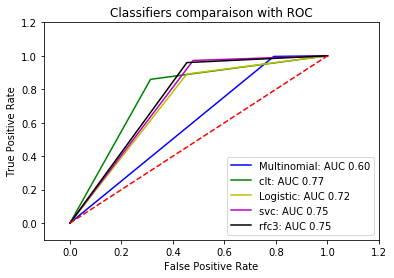

In [16]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results, although the AUC value for this method is not outstanding... 

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

# Import the tweets dataset
In this part, we will use the model we selected to generate prediction for other user comments, for example, users' comments on AUFootball Fanpage.

In [17]:
tweets = pd.read_csv('wetweets.csv', encoding = "latin")
tweets.head()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle","<p class=""TweetTextSize js-tweet-text tweet-te..."
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...,"<p class=""TweetTextSize js-tweet-text tweet-te..."
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...,"<p class=""TweetTextSize js-tweet-text tweet-te..."


In [18]:
tweets.drop(columns=['html'])

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle"
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...
...,...,...,...,...,...,...,...,...,...
49714,brianjstultz,Brian Stultz,1167588507520573442,2019-08-31 00:02:47,/brianjstultz/status/1167588507520573442,13,3,5,Wow. Just wow. #WarEagle https://twitter.com/A...
49715,tomriddle58,tomriddle,1167588208470679554,2019-08-31 00:01:36,/tomriddle58/status/1167588208470679554,0,0,0,#WAREAGLE https://www.instagram.com/p/B1zrgW1F...
49716,aucheerleading,Auburn Cheerleading,1167588137503285249,2019-08-31 00:01:19,/aucheerleading/status/1167588137503285249,26,1,2,#WarEagle from Auburn Arena! Letâs Go Auburn...
49717,Gibbs_Football,Gibbs Football,1167588071950508032,2019-08-31 00:01:03,/Gibbs_Football/status/1167588071950508032,11,0,0,Gibbs 14 Seymour 0. Barnes scores on a 6yd run...


In [19]:
message = tweets['text']

In [20]:
# convert the text info into tfidf matrix
corpus_2 = []
for text in message:
    text = str(text)
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus_2.append(text)
    
X_new_counts2 = count_vect.transform(corpus_2)
X_test_tfidf2 = tfidf_transformer.transform(X_new_counts2)

In [21]:
tweets['positive'] = clt.predict(X_test_tfidf2)
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
tweets['sentiment'] = ['positive' if x is 1 else 'negative' for x in tweets['positive']]

In [22]:
tweets.head()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html,positive,sentiment
0,Bjorn12650,Brian Olson,1162149919085359104,2019-08-15 23:51:47,/Bjorn12650/status/1162149919085359104,0,0,0,#WarEagle #HookEmHorns #OUSucks,"<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
1,WarEagle_Bands,War Eagle Bands,1162149186495832064,2019-08-15 23:48:52,/WarEagle_Bands/status/1162149186495832064,9,0,4,Donât get ready...stay ready!!pic.twitter.co...,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,negative
2,AURobUSA,ðð¤ð¡ð¸ð« Â ð¯ Pixel Pusher!,1162146524073222144,2019-08-15 23:38:17,/AURobUSA/status/1162146524073222144,1,0,0,"Thank you, I loved working on it! #WarEagle","<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
3,AuBurntOrange,AuBurntOrange,1162145863776591872,2019-08-15 23:35:40,/AuBurntOrange/status/1162145863776591872,1,0,0,Good. Looking. Picture. \r\n#WarEagle https://...,"<p class=""TweetTextSize js-tweet-text tweet-te...",1,positive
4,AuburnU,Auburn University,1162140829504483328,2019-08-15 23:15:39,/AuburnU/status/1162140829504483328,32,0,3,#Auburn admission applications for 2020 terms ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,negative


In [23]:
y = []

for x in tweets['timestamp']:
    y.append(x.isocalendar()[1])

tweets['week_number'] = y

In [24]:
print(tweets['week_number'].unique())

[33 32 31 34 42 41 43 37 40 35 38 45 44 36 39]


In [25]:
col = ['text', 'timestamp', 'sentiment']
tweets = tweets[col]
print(tweets.head(10))

                                                text           timestamp  \
0                    #WarEagle #HookEmHorns #OUSucks 2019-08-15 23:51:47   
1  Donât get ready...stay ready!!pic.twitter.co... 2019-08-15 23:48:52   
2        Thank you, I loved working on it! #WarEagle 2019-08-15 23:38:17   
3  Good. Looking. Picture. \r\n#WarEagle https://... 2019-08-15 23:35:40   
4  #Auburn admission applications for 2020 terms ... 2019-08-15 23:15:39   
5  Coach Steele: â5!!!!! 3!!!!! Canât sleep o... 2019-08-15 23:07:59   
6  We came up a little short on our last night in... 2019-08-15 23:03:59   
7  Man, looks like the #Eagles are the team to se... 2019-08-15 22:57:23   
8                            How is #ColdBlood guys? 2019-08-15 22:55:53   
9  Man, looks like the #Eagles are the team to se... 2019-08-15 22:55:46   

  sentiment  
0  positive  
1  negative  
2  positive  
3  positive  
4  negative  
5  positive  
6  negative  
7  positive  
8  positive  
9  positive  


In [26]:
# convert from string to time

tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])
week_number = []
for t in tweets['timestamp']:
    week_number.append(t.isocalendar()[1])

tweets['week_number'] = week_number

df3_senti = pd.get_dummies(tweets['sentiment'])
tweets = pd.concat([tweets,df3_senti], axis=1)

print(tweets.head())

                                                text           timestamp  \
0                    #WarEagle #HookEmHorns #OUSucks 2019-08-15 23:51:47   
1  Donât get ready...stay ready!!pic.twitter.co... 2019-08-15 23:48:52   
2        Thank you, I loved working on it! #WarEagle 2019-08-15 23:38:17   
3  Good. Looking. Picture. \r\n#WarEagle https://... 2019-08-15 23:35:40   
4  #Auburn admission applications for 2020 terms ... 2019-08-15 23:15:39   

  sentiment  week_number  negative  positive  
0  positive           33         0         1  
1  negative           33         1         0  
2  positive           33         0         1  
3  positive           33         0         1  
4  negative           33         1         0  


In [27]:
table = pd.pivot_table(tweets,index=['week_number'],aggfunc=np.sum)
print(table)

             negative  positive
week_number                    
31              428.0     785.0
32              721.0    1414.0
33              584.0    1304.0
34              653.0    1528.0
35             1476.0    5290.0
36              961.0    2621.0
37              818.0    2138.0
38             1045.0    3208.0
39              988.0    3104.0
40             1293.0    3487.0
41              778.0    1619.0
42              701.0    2017.0
43              962.0    2644.0
44              912.0    2492.0
45             1243.0    2505.0


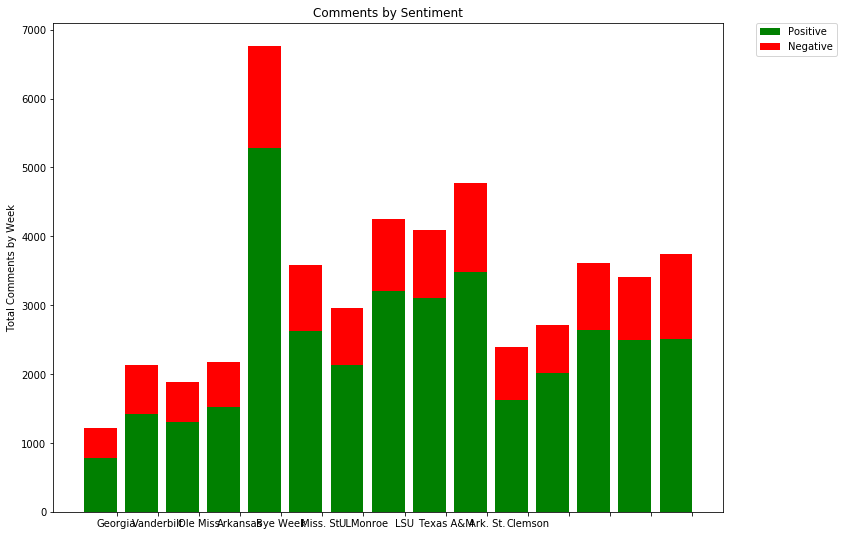

In [28]:
pos = table['positive'].values
neg = table['negative'].values
week_number = table.index

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
width = 0.8

p1 = plt.bar(week_number, pos, width, color='green',tick_label = week_number)
p2 = plt.bar(week_number, neg, width, color='red', tick_label = week_number, bottom=pos)

plt.ylabel('Total Comments by Week')
plt.title('Comments by Sentiment')
plt.xticks(week_number + width/2., ('Georgia','Vanderbilt','Ole Miss','Arkansas','Bye Week','Miss. St.','ULMonroe','LSU','Texas A&M','Ark. St.', 'Clemson'))
plt.legend((p1[0], p2[0]), ('Positive', 'Negative'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [29]:
#6 Describe the plot 

The plot is slightly skewed to the left. For each team, there were more positive comments then negative. 
The amount of negative comments look to be roughly similar for teams like Vanderbilt, Ole Miss, and Arkansas. 
LSU and Texas A&M are very close as well. Overall, there were more positive tweets than negative. 
Bye week has the most tweets; Georiga has the least.
The comprehensive sentiment is positive for each team, and had a weaker negative association.


